<a href="https://colab.research.google.com/github/niteshctrl/mask_detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries


import os
import cv2
import glob
from google.colab import drive
from google.colab import files
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


from tensorflow import keras as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
image_size = [224, 224]

anno_dir = 'annotations/'
images_dir = 'images/'
face_crops_dir = 'face_crops/'

In [ ]:
# Connect Google Drive

drive.mount('/content/gdrive')

In [2]:
# Upload Kaggle API Key


files.upload()

# Install Kaggle Library and auth permission

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission


# Data Download from Kaggle

!kaggle datasets download -d 'andrewmvd/face-mask-detection' # -p '/content/gdrive/My Drive/colab/amazon'

Saving kaggle.json to kaggle.json
kaggle.json
 96% 383M/398M [00:04<00:00, 86.6MB/s]
100% 398M/398M [00:04<00:00, 89.6MB/s]


In [ ]:
!unzip face-mask-detection.zip

In [5]:
# The annotations directory has 853 XML files with nomenclature as "maksssksksss<_>.xml" where <_> stands for a
# number ranging from 0 to 852

# Similarly for images "maksssksksss<_>.png" for corresponding image file of XML

# Since we have 3 classes(with_mask, without_mask and mask_weared_incorrect), we will dump the face crops in
# three different directories after cropping the faces.


def dump_face_crops(anno_dir, images_dir, face_crops_dir):

    if not os.path.exists(face_crops_dir+'with_mask'):
        os.makedirs(face_crops_dir+'with_mask')
    if not os.path.exists(face_crops_dir+'without_mask'):
        os.makedirs(face_crops_dir+'without_mask')
    if not os.path.exists(face_crops_dir+'mask_weared_incorrect'):
        os.makedirs(face_crops_dir+'mask_weared_incorrect')

    j = 0
    anno_files_count = len(glob.glob(anno_dir+'*'))              # Number of annotation files
    for i in range(anno_files_count):
        tree = ET.parse(anno_dir+'maksssksksss'+str(i)+'.xml')   # Parse the XML tree
        root = tree.getroot() # Get the root

        objects = root.findall('object')
        for obj in objects:                                      # Iterate through all the objects(aka faces)
            name = obj.find('name').text

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            #########################
            # Crop and save the faces
            cropped = cv2.imread(images_dir+'maksssksksss'+str(i)+'.png')
            cropped = cropped[ymin:ymax, xmin:xmax]
            cv2.imwrite(face_crops_dir+name+'/'+str(j)+'.jpg', cropped)
            j = j + 1

In [6]:
dump_face_crops(anno_dir, images_dir, face_crops_dir)

In [11]:
# model function
def model_build():
    classes_count = glob.glob(face_crops_dir+'*')

    base_model = MobileNetV2(weights='imagenet', 
                             include_top=False, 
                             input_shape=(224, 224, 3))

    head_model = base_model.output
    head_model = Flatten()(head_model)
    head_model = Dropout(0.3)(head_model)
    head_model = Dense(128, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dropout(0.3)(head_model)
    head_model = Dense(64, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dropout(0.3)(head_model)
    head_model = Dense(32, activation='relu', kernel_initializer="he_normal")(head_model)
    head_model = Dense(len(classes_count), activation='softmax')(head_model)

    # Place the head model on top of the base model

    model = Model(inputs=base_model.input, outputs=head_model)
    for layer in base_model.layers:
        layer.trainable = False

        
    model.compile(optimizer='adam', 
                  metrics=['accuracy'], 
                  loss='categorical_crossentropy'
                 )
    
    return model

In [8]:
# train

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=6,
                           restore_best_weights=True
                          )

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1, 
                                 patience=3
                                 )

model_checkpoint = ModelCheckpoint(filepath='model.hdf5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=True
                                  )

generator = ImageDataGenerator(rotation_range=10, 
                               brightness_range=(0.5, 1.5), 
                               horizontal_flip=True,
                               preprocessing_function=preprocess_input,
                               validation_split=0.2,
                              )

iterator_train = generator.flow_from_directory(face_crops_dir, 
                                               target_size=image_size,
                                               subset='training',
                                               batch_size=32
                                              )

iterator_val = generator.flow_from_directory(face_crops_dir, 
                                             target_size=image_size,
                                             subset='validation',
                                             batch_size=32
                                            )

Found 3259 images belonging to 3 classes.
Found 813 images belonging to 3 classes.


In [ ]:
model = model_build()
history = model.fit(iterator_train,
                    validation_data=iterator_val,
                    epochs=100, 
                    callbacks=[lr_scheduler, early_stop, model_checkpoint])

Epoch 1/100
102/102 [==============================] - 45s 424ms/step - loss: 2.2643 - accuracy: 0.6971 - val_loss: 0.5849 - val_accuracy: 0.8044
Epoch 2/100
102/102 [==============================] - 42s 411ms/step - loss: 0.6293 - accuracy: 0.7806 - val_loss: 0.4784 - val_accuracy: 0.7983
Epoch 3/100
102/102 [==============================] - 42s 414ms/step - loss: 0.5358 - accuracy: 0.7981 - val_loss: 0.4352 - val_accuracy: 0.8007
Epoch 4/100
102/102 [==============================] - 42s 410ms/step - loss: 0.4997 - accuracy: 0.8045 - val_loss: 0.4458 - val_accuracy: 0.8118
Epoch 5/100
102/102 [==============================] - 42s 413ms/step - loss: 0.4466 - accuracy: 0.8272 - val_loss: 0.4508 - val_accuracy: 0.8204
Epoch 6/100
102/102 [==============================] - 42s 410ms/step - loss: 0.4109 - accuracy: 0.8294 - val_loss: 0.3716 - val_accuracy: 0.8721
Epoch 7/100
102/102 [==============================] - 42s 412ms/step - loss: 0.3975 - accuracy: 0.8294 - val_loss: 0.3606 -

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

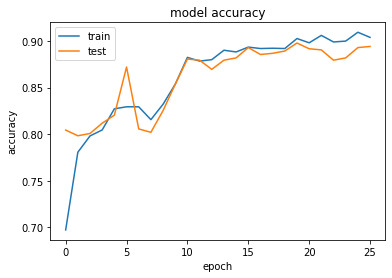

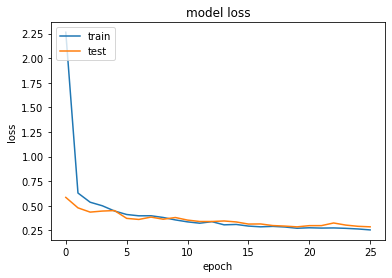

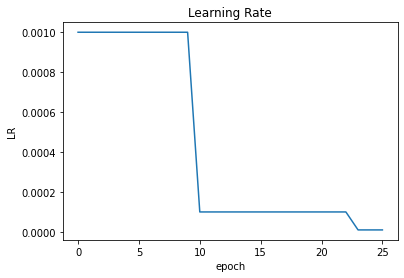

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Learning rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.ylabel('LR')
plt.xlabel('epoch')
plt.show()

In [ ]:
n_epochs = len(history.history['loss'])

In [14]:
model.save_weights('FaceMaskModel.h5')

In [15]:
model.load_weights('FaceMaskModel.h5')

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Inference

def infer():
    face_detector = cv2.CascadeClassifier('haarcascade.xml')
    vid = cv2.VideoCapture(0)

    while(True):
        _, frame = vid.read()
        grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(grey, 1.1, 4)
        
        if faces != ():
            for (x,y,w,h) in faces:
                crop = preprocess_input(frame[y:y+h, x:x+w])
                crop = cv2.resize(crop, (224,224))
                crop = crop.reshape(1,224,224,3)
                prediction = model.predict(crop)
                arg_pred = np.argmax(prediction[0])
                if arg_pred == 1: # No Mask (Box in RED Color)
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,0,255), 1)
                elif arg_pred == 0: # With Mask (Box in GREEN Color)
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 1)
                else: # Improper Mask   (Box in BLUE Color)
                    cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 1)


        cv2.imshow('Frame', frame)

        k = cv2.waitKey(30) & 0xff
        if k==27:
            break
    vid.release()
    cv2.destroyAllWindows()

In [ ]:
infer()